### TECHNICAL REPORT - ANALYSING MOVIE CATEGORIES

### PREFACE

### Problem Statement
https://github.com/tomkeith/Multi-label-classification-with-NLP


How can we classify a movie genre based on the subreddit posts using strongly asssociated words?

The management at rotten tomatoes have been interested in the potential of a classification model in determining the genre of a model through its synopsis and/or review. Through the use of natural language processing, this task may very well be possible. As such, an exploratory team has been tasked to start on a pilot model that focuses on simply 2 genres: science fiction and horror as the variable to classify upon given a paragraph of words.


Why is genre classification is imp
-  Genre is imp for recommendation of a movie
- Without the characterizations viewers face an overwhelming number of choices
- Prediction of a genre can help user to discover other similar movies of the same ilk
- This would improve the user experience



In the constant updating of the above page and its corresponding model of Rotten Tomatoes, the genre of the movie is left unseen. 

Of course, the users of rotten tomatoes would inadvertently be able to get a brief picture of the genre of the review being posted, should the model be sufficiently competent. This would improve the user experience, thereby leading to potential revisits and hence potential ad revenue.


Rotten Tomatoes would like to classify the  movie genre Sci-fi and Horror movies as a pilot. We have proposed to use scrape reddit posts to help build our model. The agency aims the following:

- Genres tell us what to expect from the movie
- Our task is to build a model to predict the genre of a movie
- Prediction of a genre can help user to discover other similar movies of the same ilk
- Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance.







A user prefers movies of particular genres more than others. What makes a genre? Which words can ‘define’ a genre? How can data answer this question? These burning questions gave rise to Genre Genie.









At least a 95% accuracy for the training set
At least a 95% accuracy for a separate testing set, unseen by the model
Test reddit model on news and articles from external websites:
What is the accuracy?
What are areas of improvement?

### Executive Summary

For this project, we will consider the 2 classes: Sci-Fi and Horror movies.
For the purposes of our analysis, we will consider the following sub-reddits as to classify the movies:

- <a href="https://www.reddit.com/r/scifimovies/">r/scifimovies</a>
- <a href="https://www.reddit.com/r/HorrorMovies/">r/HorrorMovies</a>



As reddit is limiting scrapes to only 1,000 posts per time, we will be continuously scraping and append new results to the old DataFrame.

After scraping, we will look at the most common words for each category - scifi and horror movies. After which, we will run a few models to consider if raw, pre-processed or lemmatization will yield the highest accuracy. Once we can determine the type of data, we will run a grid search on the parameters that will give the best results.

The final model is then fitted with a user-input content. User may input a real or fake news, title or body content of their liking, and run against the model

### Contents

### Table of Contents

In [189]:

import requests
import time
from datetime import datetime

import warnings
import matplotlib
import nltk
from itertools import combinations

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import numpy as np

from IPython.display import display, Markdown
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction import stop_words, text
from matplotlib.colors import LinearSegmentedColormap
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from csv import reader
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

In [151]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Data Collection


In [ ]:

- Was data collection and storage optimized through custom functions, pipelines, and/or automation?
- Was thought given to the server receiving the requests such as considering number of requests per second?


In [158]:

df_horror=pd.read_csv('./data/horrormovies_2_20200625_131436.csv')
df_scifi=pd.read_csv('./data/scifimovies_2_20200625_131211.csv')

In [164]:
df_horror.shape #Data before deleting duplicate rows

(997, 110)

In [165]:
df_scifi.shape #Data before deleting duplicate rows

(904, 111)

### Data Cleaning and EDA


In [166]:
# Deletion of duplicate rows

df_horror.drop_duplicates(subset='title', inplace=True)
df_scifi.drop_duplicates(subset='title', inplace=True)


In [167]:
df_horror.shape

(883, 110)

In [138]:
df_scifi.shape

(350, 111)

There were around 554 duplicate rows in the scifi data and 114 duplicate rows in horror movie dataframes which were dropped. This has introduced as an imbalance of 30%(scifi) : 70%(horror) in the geners which we are trying to classify.

##### Deleting null values

In [177]:
df_horror['title'].isnull().sum()

0

In [184]:
df_horror['selftext'].isnull().sum()

0

In [179]:
df_scifi['title'].isnull().sum()

0

In [183]:
df_scifi['selftext'].isnull().sum()

0

In [182]:
# Clean the null values
df_scifi['selftext'].fillna('', inplace = True) 
df_horror['selftext'].fillna('', inplace = True) 



## Explore the data

### Create the DataFrame and the target vector

In [195]:
# Create the target vector 
df_scifi['genre'] = 0 #0 for scifi
df_horror['genre'] = 1 #1 for horror
df_scifi['content'] = df_scifi[['title', 'selftext']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

df_horror['content'] = df_horror[['title', 'selftext']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [196]:
# Clean the null values
df_scifi['content'].fillna('', inplace = True) 
df_horror['content'].fillna('', inplace = True) 




### EDA - Generate a WordCloud for pre-processed Data

In [197]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

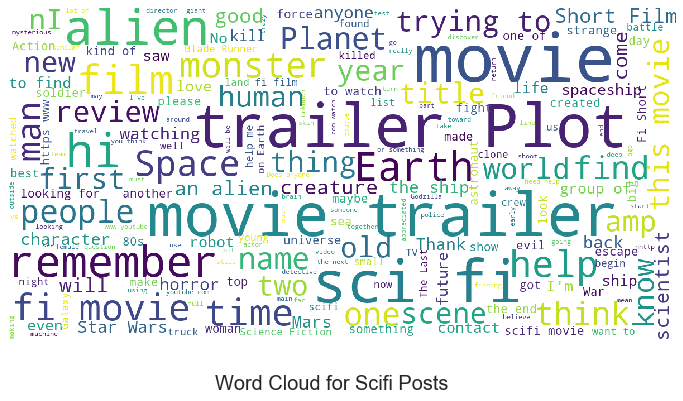

In [201]:
show_wordcloud(df_scifi['content'],'Word Cloud for Scifi Posts')


In [202]:
# Display top 10 words for df_horror
words = features(df_scifi,df_scifi.genre) #2414

2414
Top 10 words


is_horror    0
movie      171
trailer    83 
sci        73 
fi         73 
plot       71 
film       38 
earth      36 
help       35 
remember   34 
movies     33

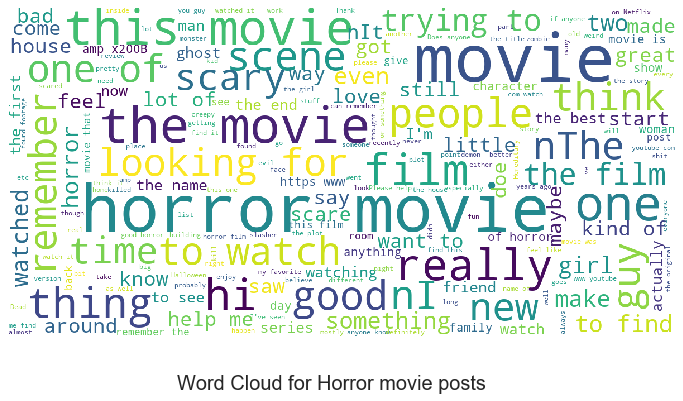

In [203]:
show_wordcloud(df_horror['content'],'Word Cloud for Horror movie posts')


In [204]:
# Display top 10 words for df_scifi
words = features(df_horror,df_horror.genre) #6739

6739
Top 10 words


is_horror    1
movie      957
horror     634
movies     428
like       409
just       285
watch      272
remember   257
film       255
good       239
really     239

### Preparation of master dataset

In [205]:

# merging title and selftext to create column 'content' to remove null values
# Merge the dtafrmaes


df_master = pd.concat([df_scifi, df_horror], ignore_index=True)
df_master = df_master[['genre', 'content','id']]
df_master.set_index("id", inplace=True)



/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [209]:
save_df_to_csv(df_master,'combined')
df_master.shape

(1233, 2)

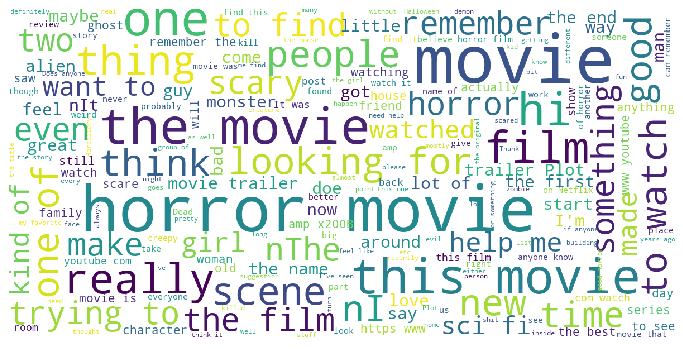

In [206]:
show_wordcloud(df_master['content'])


### Set up our data for modeling


In [210]:
X = df_master[['content']]
y = df_master['genre']

### Review distribution of the 2 Classes


In [211]:
y.value_counts(normalize=True)


1    0.716139
0    0.283861
Name: genre, dtype: float64

In [212]:
y.value_counts()

1    883
0    350
Name: genre, dtype: int64

<b>Observation:</b>
- Both classes are quite unbalanced

In [36]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y)

In [148]:
import nltk

In [218]:
st = nltk.corpus.stopwords.words('english')
newStopWords = ['movie','movies','film','horror', 'scifi', 'trailer','sci','fi']
st.extend(newStopWords)

In [222]:


###Functions

# Function to pre-process content before analysing
def clean(df, lemma):
    i = 0
    df_tmp = df
    while i < df_tmp.shape[0]:
        df_tmp.content[i] = BeautifulSoup(df_tmp.content[i]).get_text()  # Remove HTMLs
        df_tmp.content[i] = re.sub(r'^https:\/\/\S+(\/\S+)*(\/)?$', '',df_tmp.content[i], flags=re.MULTILINE)  # Remove URLs
        df_tmp.content[i] = re.sub("[^a-zA-Z]", " ", df_tmp.content[i])  # Remove non-letters
        # Convert to lower case, split into individual words
        df_tmp.content[i] = df_tmp.content[i].lower()
        if lemma == True:
            tokenizer = RegexpTokenizer(r'\w+')
            lemmatizer = WordNetLemmatizer()
            df_tmp.content[i] = tokenizer.tokenize(df_tmp.content[i])
            df_tmp.content[i] = [lemmatizer.lemmatize(j, pos="v") for j in df_tmp.content[i]]
            # Join the words back into one string separated by space, and return the result
            df_tmp.content[i] = (" ".join(df_tmp.content[i]))
        i += 1
        if i % 100 == 0:
            display(Markdown(f'Cleaned {i} rows out of {df_tmp.shape[0]}'))
    print(f'{df_tmp.shape[0]} rows cleaned')
    return df_tmp

# Function to find the features in the DataFrame
def features(df, y):
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, random_state=42, stratify=y)  # Train test split
    # Initialise CountVectorizer
    cv = CountVectorizer(stop_words='english')
    # Fit and transform content
    X_train = cv.fit_transform(X_train.content)
    # Create a DataFrame of content
    cv_train = pd.DataFrame(
        X_train.todense(), columns=cv.get_feature_names())
    words = list(cv_train.sum().sort_values(
        ascending=False).index)  # Create a list of words
    print(len(words))
    cv_train['is_horror'] = y_train.values
    cv_train = cv_train.groupby('is_horror').sum()[words]
    print(f'Top 10 words')
    display(cv_train.T.head(10))
    return words

# Function to search the best parameters
def search(vects, models, df, y, use_params):
    model_solns = {}  # Create an empty dictionary
    idx = 0  # Set model index as 0
    for v in vects:  # For each vectorizer in vects and for each model in models, perform grid search
        for m in models:
            X_train, X_test, y_train, y_test = train_test_split(
                df, y, random_state=42, stratify=y)  # Train test split and stratify by y
            idx += 1  # Inccrease the index number by 1
            # Declare vecorizer in loop as pipe_items list
            pipe_items = [v]
            pipe_items.append(m)  # Append the model to pipe_items
            [train_score, test_score, y_test, y_test_hat, best_params, f1_score] = pipeline(
                pipe_items, use_params, X_train.content, X_test.content, y_train, y_test)  # Call pipeline to perform grid search for best parameters
            model_solns[idx] = {'vectorizer': v, 'model': m, 'train_score': train_score, 'test_score': test_score,
                                'best_params': best_params, 'f1_score': f1_score}  # Add the values of grid search to model_solns dictionary
    # Display success when completed
    display(Markdown(f'<span style="color: red;"><b>COMPLETED</b></span>'))
    # Create a DataFrame from dictionary
    df_solns = pd.DataFrame(model_solns)
    # Save DataFrame as csv so we do not need to run this the next time
    df_solns.to_csv(f'./data/gridsearch.csv')
    return df_solns, X_train, X_test, y_train, train_score, test_score, y_test, y_test_hat, best_params, f1_score

# Function to search best parameters using grid search cv via pipeline
def pipeline(items, use_params, X_train, X_test, y_train, y_test):
    pipe_items = {  # Initialise vectorizers and models for our pipeline
        # Initialise CountVectorizer
        'cv': CountVectorizer(),
        # Initialise TfidfVectorizer
        'tv': TfidfVectorizer(),
        # Initialise HashingVectorizer
        'hv': HashingVectorizer(alternate_sign=True),
        'wv': Word2Vec(),
        'lr': LogisticRegression(),  # Initialise LogisticRegression
        'bnb': BernoulliNB(),  # Initialise BernoulliNB
        'mnb': MultinomialNB(),  # Initialise MultinomialNB
        'gnb': GaussianNB(),  # Initialise GaussianNB
        'knn': KNeighborsClassifier()
    }
    param_items = {  # Declare parameters for grid search
        'cv': {  # CountVectorizer parameters
            'cv__stop_words': [None, 'english'],
            'cv__ngram_range': [(1, 1), (1, 2)],  # ngram range from 1 to 3
            'cv__max_df': [0.95, 1.0],  # max df of 95% or 100%
            'cv__min_df': [1, 2],  # min df of 1 or 2 documents
            # max features from 1,000 to maximum
            'cv__max_features': [10000, 20000, 3000, None]
        },
        'tv': {  # TfidfVectorizer parameters
            'tv__stop_words': [None, 'english'],
            'tv__ngram_range': [(1, 1), (1, 2)],  # ngram range from 1 to 3
            'tv__max_df': [0.95, 1.0],  # max df of 95% or 100%
            'tv__min_df': [1, 2],  # min df of 1 or 2 documents
            # max features from 1,000 to maximum
            'tv__max_features': [10000, 20000, 3000, None]
        },
        'hv': {  # HashingVectorizer parameters
            # ngram range from 1 to 3
            'hv__ngram_range': [(1, 1), (1, 2), (1, 3)]
        },
        'wv': {

        },
        'lr': {  # LogisticRegression parameters
            'lr__C': [1, .05],  # Inverse alpha of 1 and 0.05
            'lr__penalty': ['l1', 'l2']  # L1 or L2 regularization
        },
        'bnb': {  # BernoulliNB parameters
            # alpha range from 0.0001 to 1.0
            'bnb__alpha': [0.0001, 0.01, 1.0]
        },
        'mnb': {  # MultinomialNB parameters
            # alpha range from 0.0001 to 1.0
            'mnb__alpha': [0.0001, 0.01, 1.0]
        },
        'gnb': {  # GaussianNB parameters
        },
        'knn': {
            'knn__n_neighbors': [35, 200]
        }
    }
    params = dict()  # Create the parameters for GridSearch
    if use_params:
        for i in items:  # for each vectorizer,
            for p in param_items[i]:  # for each parameter
                # set parameters for vectorizer in the dictionary
                params[p] = param_items[i][p]
    pipe_list = [(i, pipe_items[i]) for i in items]
    method = list()  # create an empty list
    for p in pipe_list:  # for each vectorizer in pipeline
        # append values to method list
        method.append(str(p[1]).split('(')[0])
    # Display vectorizer and model used for current grid search
    display(Markdown(f'<b>Using {method[0]} with {method[1]}</b>'))
    pipe = Pipeline(pipe_list)  # Create the pipeline
    # Perform grid search for the vectorizer and parameters in pipeline. Verbose set to 1 to display progress
    gs = GridSearchCV(pipe, param_grid=params,
                      verbose=1, pre_dispatch=None, cv=2)
    # fit values of grid search onto X_train and y_train
    gs.fit(X_train, y_train)
    train_params = gs.best_params_  # Declare the best parameters for model
    train_score = gs.best_score_  # Declare training score for model
    y_test_hat = gs.predict(X_test)  # Predict target from model
    test_score = gs.score(X_test, y_test)  # Accuracy of model
    for k in train_params:  # For each parameter in grid search,
        print(f"{k}: {train_params[k]}")  # Print parameter used
    print(f'\nTrain score: {train_score}')  # Print training score
    print(f'Test score: {test_score} (Accuracy)\n')  # Print accuracy
    tn, fp, fn, tp = confusion_matrix(
        y_test, y_test_hat).ravel()  # Get the confusion matrix
    f1_score = 2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))
    print(f"True Negatives: {tn}")  # Predicted real news correctly
    # Predicted fake news incorrectly
    print(f"False Positives: {fp} (Type I Error)")
    # Predicted real news incorrectly
    print(f"False Negatives: {fn} (Type II Error)")
    print(f"True Positives: {tp}\n")  # Predicted fake news correctly
    # Display completed banner
    display(Markdown(f'<b>Sensitivity:</b> {tp/(tp+fn)}'))
    display(Markdown(f'<b>Miss Rate:</b> {fn/(tp+fn)}'))
    display(Markdown(f'<b>Specificity:</b> {tn/(fp+tn)}'))
    display(Markdown(f'<b>Fall Out Rate:</b> {fp/(fp+tn)}'))
    print()
    display(Markdown(f'<b>Precision:</b> {tp/(tp+fp)}'))
    display(Markdown(f'<b>False Discovery Rate:</b> {fp/(tp+fp)}'))
    display(Markdown(f'<b>Negative Predictive Value:</b> {tn/(tn+fn)}'))
    display(Markdown(f'<b>False Omission Rate:</b> {fn/(tn+fn)}'))
    print()
    display(Markdown(f'<b>Prevalence:</b> {(tp+fn)/(tp+fp+tn+fn)}'))
    display(Markdown(f'<b>Accuracy:</b> {(tp+tn)/(tp+fp+tn+fn)}'))
    print()
    display(Markdown(f'<b>Positive Likelihood Ratio:</b> {(tp/(tp+fn))/(fp/(fp+tn))}'))
    display(Markdown(f'<b>Negative Likelihood Ratio:</b> {(fn/(tp+fn))/(tn/(fp+tn))}'))
    display(Markdown(f'<b>Diagnostic Odds Ratio:</b> {((tp/(tp+fn))/(fp/(fp+tn)))/((fn/(tp+fn))/(tn/(fp+tn)))}'))
    display(Markdown(f'<b>F1 Score:</b> {2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))}'))
    print()
    display(Markdown(f'<span style="color: red;"><b>****Completed {method[0]} with {method[1]}****<b></span>'))
    print()
    print()
    return train_score, test_score, y_test, y_test_hat, train_params, f1_score




In [ ]:
#    cv_train = cv_train.groupby('is_horror').sum()[words]


In [221]:
# Initialize an empty list to hold the clean messages.
clean_train_text = []
clean_test_text = []

print("Cleaning and parsing the training set messages...")

# Instantiate counter.
j = 0

# For every message in our training set...
for train_content in X_train['content']:
    
    # Convert messages to words, then append to clean_train_message.
    clean_train_text.append(clean(train_content))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Message {j + 1} of {total_content}.')
    
    j += 1

# Do the same for the testing set.
print("Cleaning and parsing the testing set messages...")

# For every message in our testing set...
for test_text in X_test['content']:
    
    # Convert messages to words, then append to clean_train_message.
    clean_test_text.append(clean(test_text))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Message {j + 1} of {total_content}.')
        
    j += 1

Cleaning and parsing the training set messages...
Message 100 of 1233.
Message 200 of 1233.
Message 300 of 1233.
Message 400 of 1233.
Message 500 of 1233.
Message 600 of 1233.
Message 700 of 1233.
Message 800 of 1233.
Message 900 of 1233.
Cleaning and parsing the testing set messages...
Message 1000 of 1233.
Message 1100 of 1233.
Message 1200 of 1233.


## Run a simple CountVectorizer and explore


In [214]:
cv_simple = CountVectorizer(stop_words='english',
                            binary = True,
                            ngram_range=(1,4),
                            min_df=2)
X_cv = cv_simple.fit_transform(df_master['content'])


cv_train = pd.DataFrame(X_cv.todense(), columns=cv_simple.get_feature_names())


In [215]:
cv_train.head()

000  000 leagues  10  10 10  10 acting  10 https  10 https imdb  \
0  0    0            0   0      0          0         0               
1  0    0            0   0      0          0         0               
2  0    0            0   0      0          0         0               
3  0    0            0   0      0          0         0               
4  0    0            0   0      0          0         0               

   10 https imdb com  10 minutes  10 movie  10 plot  10 probably  10 watch  \
0  0                  0           0         0        0            0          
1  0                  0           0         0        0            0          
2  0                  0           0         0        0            0          
3  0                  0           0         0        0            0          
4  0                  0           0         0        0            0          

   10 year  10 year old  10 years  100  11  12  13  13 years  13th  \
0  0        0            0         0    0   0   0   0         0      
1  0        0            0         0    0   0   0   0         0      
2  0        0            0         0    0   0   0   0         0      
3  0        0            0         0    0   0   0   0         0      
4  0        0            0         0    0   0   0   0         0      

   13th halloween  1408  15  15 years  16  16 18  17  18  1955  1955 movie  \
0  0               0     0   0         0   0      0   0   0     0            
1  0               0     0   0         0   0      0   0   0     0            
2  0               0     0   0         0   0      0   0   0     0            
3  0               0     0   0         0   0      0   0   0     0            
4  0               0     0   0         0   0      0   0   0     0            

   1955 movie trailer  1955 movie trailer plot  1956  1956 movie  \
0  0                   0                        0     0            
1  0                   0                        0     0            
2  0                   0                        0     0            
3  0                   0                        0     0            
4  0                   0                        0     0            

   1956 movie trailer  1956 movie trailer plot  1957  1957 movie  \
0  0                   0                        0     0            
1  0                   0                        1     1            
2  0                   0                        0     0            
3  0                   0                        0     0            
4  0                   0                        0     0            

   1957 movie trailer  1957 movie trailer plot  1958  1958 movie  \
0  0                   0                        1     1            
1  1                   1                        0     0            
2  0                   0                        0     0            
3  0                   0                        0     0            
4  0                   0                        0     0            

   1958 movie trailer  1958 movie trailer plot  1959  1959 movie  \
0  1                   1                        0     0            
1  0                   0                        0     0            
2  0                   0                        0     0            
3  0                   0                        0     0            
4  0                   0                        0     0            

   1959 movie trailer  1959 movie trailer plot  1960  1960 movie  \
0  0                   0                        0     0            
1  0                   0                        0     0            
2  0                   0                        0     0            
3  0                   0                        0     0            
4  0                   0                        0     0            

   1960 movie trailer  1960 movie trailer plot  1960s  1961  1963  1963 movie  \
0  0                   0                        0      0     0     0            
1  0            

In [216]:
cv_train.shape

(1233, 7746)

abandon  abc  abdomen  abduct  abduction  abductions  abeal  abed  \
is_horror                                                                      
0          1        1    0        2       0          1           0      0      
1          15       0    2        0       1          0           1      1      

           abilities  ability  abit  able  aboard  aboit  abominable  abrams  \
is_horror                                                                      
0          0          0        0     3     1       0      0           1        
1          1          4        1     26    0       1      1           0        

           abrasive  absence  absent  absentia  absolute  absolutely  absorb  \
is_horror                                                                      
0          0         0        0       0         0         0           1        
1          1         1        1       1         9         11          0        

           absurd  absurdity  abt  abunch  aburtly  abuse  abusive  aby  \
is_horror                                                                 
0          1       0          0    0       0        0      1        1     
1          0       2          1    1       1        4      2        0     

           abysmal  academy  accent  accentuate  accept  acceptable  access  \
is_horror                                                                     
0          0        0        0       0           1       0           0        
1          1        3        3       1           0       1           2        

           accident  accidentally  acclaim  accompany  accord  accordeur  \
is_horror                                                                  
0          3         4             0        1          0       0           
1          4         3             2        1          5       2           

           accordingly  account  accrue  accumulate  accurate  accuse  \
is_horror                                                               
0          0            0        1       0           1         0        
1          1            2        0       2           2         1        

           accustom  acdc  acid  acknowledge  acquire  act  action  active  \
is_horror                                                                    
0          0         0     2     0            0        3    10      0        
1          1         1     2     1            1        89   9       2        

           activities  activity  actor  actors  actress  actresses  actual  \
is_horror                                                                    
0          0           0         4      2       0        0          0        
1          1           16        9      13      7        1          13       

           actually  acutely  ad  ada  adam  adapt  adaptation  adaptations  \
is_horror                                                                     
0          3         0        2   1    1     0      0           0             
1          71        1        1   0    1     2      5           2             

           add  addams  addict  addiction  addition  adhere  admins  \
is_horror                                                             
0          1    0       0       0          0         0       0        
1          36   2       1       2          1         1       1        

           admission  admit  admittedly  adopt  adore  adrenaline  adrian  \
is_horror                                                                   
0          1          1      0           0      0      1           0        
1          0          5      2           1      2      2           1        

           ads  adult  adults  advance  advancement  advantage  adventure  \
is_horror                                                                   
0          0    0      0       4        0            0          1           
1          2    8      7       25       1            1          

In [113]:
# Create a data frame of the most common words 

n_words = 40
words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['is_horror'] = df_master['is_horror'].values
cv_train_small = cv_train.groupby('is_horror').sum()[words]
cv_train_small.T


is_horror        0    1
movie          162  547
horror         10   484
watch          31   410
movies         30   337
like           34   323
think          26   247
just           15   254
know           18   242
film           43   194
help           36   201
good           14   220
remember       31   189
ve             19   192
look           25   185
make           22   182
really         7    194
horror movies  1    185
horror movie   2    183
time           26   141
try            19   145
plot           92   64 
end            15   137
come           22   129
want           17   132
don            6    140
people         20   121
thank          18   122
trailer        111  24 
love           11   123
guy            7    125
say            4    128
scene          10   110
saw            11   105
need           11   105
lot            10   104
feel           1    108
kill           17   90 
start          11   96 
scary          0    106
years          14   86

ValueError: shape mismatch: objects cannot be broadcast to a single shape

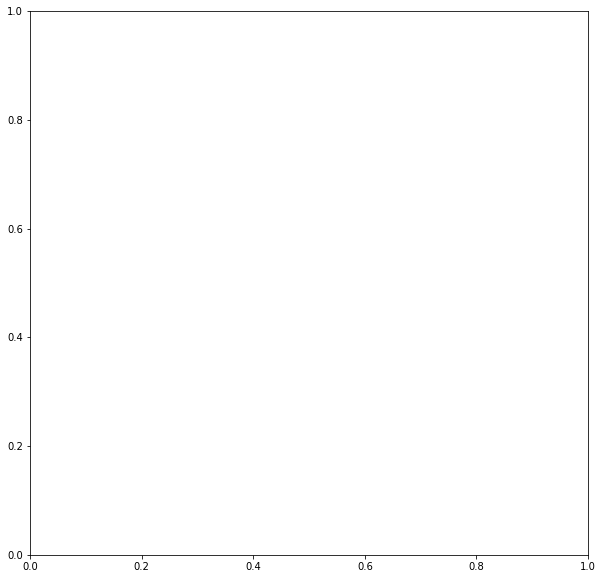

In [121]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html

words_horror = words
words_count_horror = cv_train_small.loc[1]
words_scifi = words
words_count_scifi = cv_train_small.loc[0]
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(ind, words_count_horror, width, color=colors[0])
rects2 = ax.bar(ind+width,words_count_scifi, width, color=colors[5])

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word and reddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,100)

ax.legend((rects1[0], rects2[0]), ('Horror', 'Scifi'))

plt.show()

### Run a simple TfidfVectorizer and explore

In [116]:
tv_simple = TfidfVectorizer(stop_words='english',
                            binary = True,
                            ngram_range=(1,2),
                            #token_pattern=r'(?u)\b\w+\b',
                            min_df=2)
X_tv = tv_simple.fit_transform(df_master['content'])

tv_train = pd.DataFrame(X_tv.todense(), columns=tv_simple.get_feature_names())
tv_train.head()

abandon  abandon asylum  abandon build  abdomen  abduct  ability  able  \
0  0.0      0.0             0.0            0.0      0.0     0.0      0.0    
1  0.0      0.0             0.0            0.0      0.0     0.0      0.0    
2  0.0      0.0             0.0            0.0      0.0     0.0      0.0    
3  0.0      0.0             0.0            0.0      0.0     0.0      0.0    
4  0.0      0.0             0.0            0.0      0.0     0.0      0.0    

   able figure  able hurt  able thank  absolute  absolutely  absolutely worth  \
0  0.0          0.0        0.0         0.0       0.0         0.0                
1  0.0          0.0        0.0         0.0       0.0         0.0                
2  0.0          0.0        0.0         0.0       0.0         0.0                
3  0.0          0.0        0.0         0.0       0.0         0.0                
4  0.0          0.0        0.0         0.0       0.0         0.0                

   absurdity  abuse  abusive  academy  accent  access  accident  accidentally  \
0  0.0        0.0    0.0      0.0      0.0     0.0     0.0       0.0            
1  0.0        0.0    0.0      0.0      0.0     0.0     0.0       0.0            
2  0.0        0.0    0.0      0.0      0.0     0.0     0.0       0.0            
3  0.0        0.0    0.0      0.0      0.0     0.0     0.0       0.0            
4  0.0        0.0    0.0      0.0      0.0     0.0     0.0       0.0            

   acclaim  accompany  accord  account  accumulate  accurate  acid  act  \
0  0.0      0.0        0.0     0.0      0.0         0.0       0.0   0.0   
1  0.0      0.0        0.0     0.0      0.0         0.0       0.0   0.0   
2  0.0      0.0        0.0     0.0      0.0         0.0       0.0   0.0   
3  0.0      0.0        0.0     0.0      0.0         0.0       0.0   0.0   
4  0.0      0.0        0.0     0.0      0.0         0.0       0.0   0.0   

   act act  act bad  act film  act good  act great  act just  act lead  \
0  0.0      0.0      0.0       0.0       0.0        0.0       0.0        
1  0.0      0.0      0.0       0.0       0.0        0.0       0.0        
2  0.0      0.0      0.0       0.0       0.0        0.0       0.0        
3  0.0      0.0      0.0       0.0       0.0        0.0       0.0        
4  0.0      0.0      0.0       0.0       0.0        0.0       0.0        

   act like  act make  act movie  act overall  act point  act really  \
0  0.0       0.0       0.0        0.0          0.0        0.0          
1  0.0       0.0       0.0        0.0          0.0        0.0          
2  0.0       0.0       0.0        0.0          0.0        0.0          
3  0.0       0.0       0.0        0.0          0.0        0.0          
4  0.0       0.0       0.0        0.0          0.0        0.0          

   act sexual  action  action happen  action movie  action sci  \
0  0.0         0.0     0.0            0.0           0.0          
1  0.0         0.0     0.0            0.0           0.0          
2  0.0         0.0     0.0            0.0           0.0          
3  0.0         0.0     0.0            0.0           0.0          
4  0.0         0.0     0.0            0.0           0.0          

   action thriller  active  activity  activity movie  activity movies  actor  \
0  0.0              0.0     0.0       0.0             0.0              0.0     
1  0.0              0.0     0.0       0.0             0.0              0.0     
2  0.0              0.0     0.0       0.0             0.0              0.0     
3  0.0              0.0     0.0       0.0             0.0              0.0     
4  0.0              0.0     0.0       0.0             0.0              0.0     

   actors  actors film  actors ve  actress  actress play  actual  \
0  0.0     0.0          0.0        0.0      0.0           0.0      
1  0.0     0.0          0.0        0.0      0.0           0.0      
2  0.0     0.0          0.0        0.0      0.0           0.0      
3  0.0     0.0          0.0        0.0      0.0           0.0      
4  0.0     0.0     

In [118]:
# Create a data frame of the most common words 

n_words = 20
words = list(tv_train.sum().sort_values(ascending=False)[:].index)
tv_train['is_horror'] = df_master['is_horror'].values
tv_train_small = tv_train.groupby('is_horror').sum()[words]
tv_train_small.head().T

is_horror                           0          1
movie                       11.170963  28.329760
horror                      0.844421   32.547902
movies                      2.945443   27.297203
watch                       3.076058   26.976830
like                        2.577646   20.350026
trailer                     19.219514  2.560158 
horror movies               0.145779   20.869566
good                        1.755634   19.248196
just                        2.180945   18.637712
know                        1.456973   18.985569
film                        6.228986   14.164773
help                        3.894047   16.262008
think                       2.262451   17.803355
horror movie                0.149669   18.250582
look                        2.360100   15.180674
plot                        12.467968  4.761572 
remember                    2.610647   14.575138
ve                          1.568277   14.999734
really                      0.581753   15.146141
movie trailer               15.308953  0.155750 
make                        2.000168   12.710048
trailer plot                14.484585  0.000000 
fi                          13.420774  0.981965 
sci fi                      13.420774  0.981965 
sci                         13.420774  0.981965 
time                        2.928372   11.217752
thank                       1.676047   12.074905
try                         1.803164   11.766310
want                        1.855541   11.680615
guy                         0.765908   12.500764
love                        2.086417   10.916745
end                         1.265495   11.396308
come                        2.332968   10.084055
don                         0.678780   11.678043
people                      2.181215   9.882109 
need                        1.279597   10.739073
alien                       9.098248   2.800122 
suggestions                 0.359767   10.687778
scary                       0.000000   10.932331
saw                         1.239398   9.597347 
new                         2.573600   8.178446 
scene                       0.995637   9.653093 
say                         0.452388   10.000913
best                        0.862510   9.330896 
lot                         1.137783   8.819326 
netflix                     1.235683   8.703467 
kill                        2.064262   7.846186 
man                         4.251741   5.573456 
years                       1.557197   7.959802 
start                       1.516616   7.934477 
house                       0.167441   9.089563 
title                       1.352437   7.644097 
feel                        0.123499   8.861171 
girl                        0.463976   8.502348 
old                         1.818631   7.111220 
thing                       1.829625   6.885070 
night                       1.216161   7.367579 
use                         1.969335   6.458421 
maybe                       0.924979   7.492631 
short                       6.114247   2.210166 
favorite                    0.338372   7.838365 
recommendations             0.212407   7.846886 
ago                         0.772068   7.247971 
kind                        1.306585   6.616794 
pretty                      0.952757   6.885555 
little                      0.125322   7.632215 
recommend                   0.449363   7.298460 
scar                        0.340329   7.380492 
great                       0.456439   7.197619 
review                      4.895443   2.723226 
series                      1.120932   6.459100 
character                   0.911968   6.651617 
way                         0.545767   6.831141 
turn                        1.468188   5.744979 
help movie                  0.884205   6.274232 
ones                        0.000000   7.057234 
post                        1.738348   5.260578 
star                        4.739224   2.175565 
place                       0.630310   6.258614 
kid                         0.943792   5.918459 
happen                      0.2

In [344]:
tv_train_small.head().T

is_horror           0           1
is_cape      0.000000  663.000000
like         2.164582   23.106736
remember     3.152863   20.107699
good         1.614013   21.623397
watch        1.662785   19.518202
help         3.606714   15.115400
know         1.278129   17.260938
think        2.415855   14.610280
really       0.342928   16.253989
seen         0.757485   14.901642
watched      0.735321   14.439350
looking      1.374722   12.814222
scary        0.000000   13.157628
plot         8.420188    3.934463
netflix      0.871119   10.629293
people       2.016823    8.728712
suggestions  0.195760   10.440798
time         2.037020    8.519355
watching     1.044543    9.065993
need         1.135174    8.735922

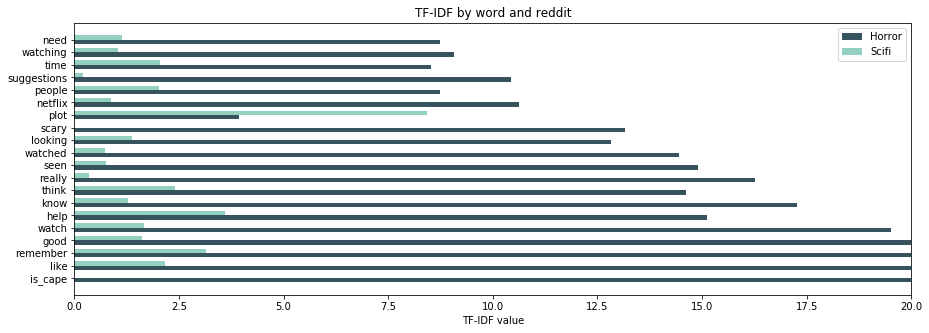

In [343]:

words_horror = words
words_count_horror = tv_train_small.loc[1]
words_scifi = words
words_count_scifi = tv_train_small.loc[0]
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.barh(ind, words_count_horror, width, color=colors[0])
rects2 = ax.barh(ind+width,words_count_scifi, width, color=colors[5])

# add some text for labels, title and axes ticks
ax.set_xlabel('TF-IDF value')
ax.set_title('TF-IDF by word and reddit')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words)  #,rotation='vertical')

ax.set_xlim(0,20)

ax.legend((rects1[0], rects2[0]), ('Horror', 'Scifi'))

plt.show()

In [ ]:
# Create a data frame of the most common words 

n_words = 40
words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['is_horror'] = y_train.values
cv_train_small = cv_train.groupby('is_horror').sum()[words]
cv_train_small.head()


In [ ]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

words_horror = words
words_count_horror = cv_train_small.loc[1]
words_scifi = words
words_count_scifi = cv_train_small.loc[0]
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(ind, words_count_horror, width, color=colors[0])
rects2 = ax.bar(ind+width,words_count_scifi, width, color=colors[5])

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word and reddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,80)

ax.legend((rects1[0], rects2[0]), ('Horror Movies', 'Scifi Movies'))

plt.show()


## Baseline Score

In [38]:

# Check the classification. 1 = fake news, 0 = real news
y.value_counts(normalize=True)

1    0.717532
0    0.282468
Name: is_horror, dtype: float64

### Model with Raw Data

In [49]:
# Enter what vectorizers and classifiers we want to use and find the best.

vectorizer = ['cv','tv']
classifier = ['lr','bnb','mnb','knn']
use_params = False

df_solns, X_train, X_test, y_train, train_score, test_score, y_test, y_test_hat, best_params, f1_score = search(vectorizer,classifier,df_master,y,use_params)

<b>Using CountVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.908008658008658
Test score: 0.9318181818181818 (Accuracy)

True Negatives: 74
False Positives: 13 (Type I Error)
False Negatives: 8 (Type II Error)
True Positives: 213



/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>Sensitivity:</b> 0.9638009049773756

<b>Miss Rate:</b> 0.03619909502262444

<b>Specificity:</b> 0.8505747126436781

<b>Fall Out Rate:</b> 0.14942528735632185

<b>Precision:</b> 0.9424778761061947

<b>False Discovery Rate:</b> 0.05752212389380531

<b>Negative Predictive Value:</b> 0.9024390243902439

<b>False Omission Rate:</b> 0.0975609756097561

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9318181818181818

<b>Positive Likelihood Ratio:</b> 6.450052210233205

<b>Negative Likelihood Ratio:</b> 0.04255839549957197

<b>Diagnostic Odds Ratio:</b> 151.5576923076923

<b>F1 Score:</b> 0.953020134228188

<span style="color: red;"><b>****Completed CountVectorizer with LogisticRegression****<b></span>

<b>Using CountVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



Train score: 0.8387445887445888
Test score: 0.8409090909090909 (Accuracy)

True Negatives: 72
False Positives: 15 (Type I Error)
False Negatives: 34 (Type II Error)
True Positives: 187



<b>Sensitivity:</b> 0.8461538461538461

<b>Miss Rate:</b> 0.15384615384615385

<b>Specificity:</b> 0.8275862068965517

<b>Fall Out Rate:</b> 0.1724137931034483

<b>Precision:</b> 0.9257425742574258

<b>False Discovery Rate:</b> 0.07425742574257425

<b>Negative Predictive Value:</b> 0.6792452830188679

<b>False Omission Rate:</b> 0.32075471698113206

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8409090909090909

<b>Positive Likelihood Ratio:</b> 4.907692307692307

<b>Negative Likelihood Ratio:</b> 0.1858974358974359

<b>Diagnostic Odds Ratio:</b> 26.399999999999995

<b>F1 Score:</b> 0.884160756501182

<span style="color: red;"><b>****Completed CountVectorizer with BernoulliNB****<b></span>

<b>Using CountVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished



Train score: 0.8495670995670995
Test score: 0.8928571428571429 (Accuracy)

True Negatives: 54
False Positives: 33 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6206896551724138

<b>Fall Out Rate:</b> 0.3793103448275862

<b>Precision:</b> 0.8700787401574803

<b>False Discovery Rate:</b> 0.12992125984251968

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8928571428571429

<b>Positive Likelihood Ratio:</b> 2.6363636363636367

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9305263157894736

<span style="color: red;"><b>****Completed CountVectorizer with MultinomialNB****<b></span>

<b>Using CountVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished



Train score: 0.7564935064935064
Test score: 0.7597402597402597 (Accuracy)

True Negatives: 71
False Positives: 16 (Type I Error)
False Negatives: 58 (Type II Error)
True Positives: 163



<b>Sensitivity:</b> 0.7375565610859729

<b>Miss Rate:</b> 0.26244343891402716

<b>Specificity:</b> 0.8160919540229885

<b>Fall Out Rate:</b> 0.1839080459770115

<b>Precision:</b> 0.9106145251396648

<b>False Discovery Rate:</b> 0.0893854748603352

<b>Negative Predictive Value:</b> 0.5503875968992248

<b>False Omission Rate:</b> 0.4496124031007752

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.7597402597402597

<b>Positive Likelihood Ratio:</b> 4.010463800904978

<b>Negative Likelihood Ratio:</b> 0.3215856223312727

<b>Diagnostic Odds Ratio:</b> 12.470905172413794

<b>F1 Score:</b> 0.815

<span style="color: red;"><b>****Completed CountVectorizer with KNeighborsClassifier****<b></span>

<b>Using TfidfVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished



Train score: 0.8820346320346321
Test score: 0.9123376623376623 (Accuracy)

True Negatives: 64
False Positives: 23 (Type I Error)
False Negatives: 4 (Type II Error)
True Positives: 217



/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>Sensitivity:</b> 0.9819004524886877

<b>Miss Rate:</b> 0.01809954751131222

<b>Specificity:</b> 0.735632183908046

<b>Fall Out Rate:</b> 0.26436781609195403

<b>Precision:</b> 0.9041666666666667

<b>False Discovery Rate:</b> 0.09583333333333334

<b>Negative Predictive Value:</b> 0.9411764705882353

<b>False Omission Rate:</b> 0.058823529411764705

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9123376623376623

<b>Positive Likelihood Ratio:</b> 3.7141451898485145

<b>Negative Likelihood Ratio:</b> 0.024604072398190048

<b>Diagnostic Odds Ratio:</b> 150.9565217391304

<b>F1 Score:</b> 0.9414316702819956

<span style="color: red;"><b>****Completed TfidfVectorizer with LogisticRegression****<b></span>

<b>Using TfidfVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished



Train score: 0.8387445887445888
Test score: 0.8409090909090909 (Accuracy)

True Negatives: 72
False Positives: 15 (Type I Error)
False Negatives: 34 (Type II Error)
True Positives: 187



<b>Sensitivity:</b> 0.8461538461538461

<b>Miss Rate:</b> 0.15384615384615385

<b>Specificity:</b> 0.8275862068965517

<b>Fall Out Rate:</b> 0.1724137931034483

<b>Precision:</b> 0.9257425742574258

<b>False Discovery Rate:</b> 0.07425742574257425

<b>Negative Predictive Value:</b> 0.6792452830188679

<b>False Omission Rate:</b> 0.32075471698113206

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8409090909090909

<b>Positive Likelihood Ratio:</b> 4.907692307692307

<b>Negative Likelihood Ratio:</b> 0.1858974358974359

<b>Diagnostic Odds Ratio:</b> 26.399999999999995

<b>F1 Score:</b> 0.884160756501182

<span style="color: red;"><b>****Completed TfidfVectorizer with BernoulliNB****<b></span>

<b>Using TfidfVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



Train score: 0.7413419913419913
Test score: 0.7694805194805194 (Accuracy)

True Negatives: 16
False Positives: 71 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.1839080459770115

<b>Fall Out Rate:</b> 0.8160919540229885

<b>Precision:</b> 0.7568493150684932

<b>False Discovery Rate:</b> 0.24315068493150685

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.7694805194805194

<b>Positive Likelihood Ratio:</b> 1.2253521126760563

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.861598440545809

<span style="color: red;"><b>****Completed TfidfVectorizer with MultinomialNB****<b></span>

<b>Using TfidfVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished



Train score: 0.8506493506493507
Test score: 0.9025974025974026 (Accuracy)

True Negatives: 57
False Positives: 30 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6551724137931034

<b>Fall Out Rate:</b> 0.3448275862068966

<b>Precision:</b> 0.8804780876494024

<b>False Discovery Rate:</b> 0.11952191235059761

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9025974025974026

<b>Positive Likelihood Ratio:</b> 2.9

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9364406779661016

<span style="color: red;"><b>****Completed TfidfVectorizer with KNeighborsClassifier****<b></span>

<span style="color: red;"><b>COMPLETED</b></span>

In [50]:

# Display the best model
df_solns = df_solns.sort_values(ascending=False, by='f1_score',axis=1)
df_solns.iloc[:,0:1]

1
vectorizer   cv      
model        lr      
train_score  0.908009
test_score   0.931818
best_params  {}      
f1_score     0.95302

For our benchmark ($M_0$) model, we will use cv with LogisticRegression which yields an F1 Score of 0.95302.

## Model with Processed Data



In this model, we will use BeautifulSoup and RegEx to clean our data. However, we will not use Lemmatization for this model. Stopwords are not removed as well.

In [54]:
# Clean the training data and assign it to df_processed
df_processed = clean(df_master,lemma=False)

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

1232 rows cleaned


Let us see if the number of words dropped after cleaning.

In [58]:
# Display top 10 words for processed data
words_unprocessed = features(df_master,y)

7564
Top 10 words


is_horror    0    1
movie      170  934
horror     7    661
movies     30   434
like       28   401
just       13   323
remember   37   273
film       42   265
watch      18   283
good       10   235
help       31   204

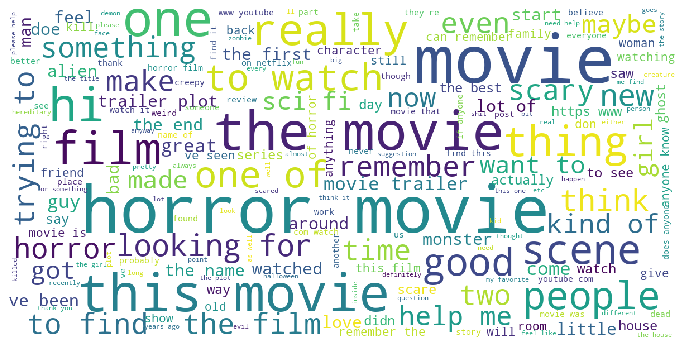

In [56]:
# Display wordcloud for df
show_wordcloud(df_processed['content'])

In [57]:
# Display top 10 words for processed data
words_processed = features(df_processed,y)

7564
Top 10 words


is_horror    0    1
movie      170  934
horror     7    661
movies     30   434
like       28   401
just       13   323
remember   37   273
film       42   265
watch      18   283
good       10   235
help       31   204


We can see that the number of features dropped from xxx to xxx. The top common words did not change though, with trump, russia and mueller in the top 10.

Let us find out what is the best model for our $M_1$.

In [61]:
# Enter what vectorizers and classifiers we want to use and find the best.

vectorizer = ['cv','tv']
classifier = ['lr','bnb','mnb','knn']
use_params = False

df_solns, X_train, X_test, y_train, train_score, test_score, y_test, y_test_hat, best_params, f1_score = search(vectorizer,classifier,df_master,y,use_params)

<b>Using CountVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.908008658008658
Test score: 0.935064935064935 (Accuracy)

True Negatives: 74
False Positives: 13 (Type I Error)
False Negatives: 7 (Type II Error)
True Positives: 214



/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>Sensitivity:</b> 0.9683257918552036

<b>Miss Rate:</b> 0.03167420814479638

<b>Specificity:</b> 0.8505747126436781

<b>Fall Out Rate:</b> 0.14942528735632185

<b>Precision:</b> 0.9427312775330396

<b>False Discovery Rate:</b> 0.05726872246696035

<b>Negative Predictive Value:</b> 0.9135802469135802

<b>False Omission Rate:</b> 0.08641975308641975

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.935064935064935

<b>Positive Likelihood Ratio:</b> 6.480334145492516

<b>Negative Likelihood Ratio:</b> 0.03723859606212548

<b>Diagnostic Odds Ratio:</b> 174.021978021978

<b>F1 Score:</b> 0.9553571428571429

<span style="color: red;"><b>****Completed CountVectorizer with LogisticRegression****<b></span>

<b>Using CountVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



Train score: 0.8344155844155844
Test score: 0.8344155844155844 (Accuracy)

True Negatives: 72
False Positives: 15 (Type I Error)
False Negatives: 36 (Type II Error)
True Positives: 185



<b>Sensitivity:</b> 0.8371040723981901

<b>Miss Rate:</b> 0.16289592760180996

<b>Specificity:</b> 0.8275862068965517

<b>Fall Out Rate:</b> 0.1724137931034483

<b>Precision:</b> 0.925

<b>False Discovery Rate:</b> 0.075

<b>Negative Predictive Value:</b> 0.6666666666666666

<b>False Omission Rate:</b> 0.3333333333333333

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8344155844155844

<b>Positive Likelihood Ratio:</b> 4.855203619909502

<b>Negative Likelihood Ratio:</b> 0.19683257918552036

<b>Diagnostic Odds Ratio:</b> 24.666666666666664

<b>F1 Score:</b> 0.8788598574821853

<span style="color: red;"><b>****Completed CountVectorizer with BernoulliNB****<b></span>

<b>Using CountVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train score: 0.8463203463203464
Test score: 0.8896103896103896 (Accuracy)

True Negatives: 53
False Positives: 34 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6091954022988506

<b>Fall Out Rate:</b> 0.39080459770114945

<b>Precision:</b> 0.8666666666666667

<b>False Discovery Rate:</b> 0.13333333333333333

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8896103896103896

<b>Positive Likelihood Ratio:</b> 2.5588235294117645

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9285714285714286

<span style="color: red;"><b>****Completed CountVectorizer with MultinomialNB****<b></span>

<b>Using CountVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Train score: 0.7521645021645021
Test score: 0.7532467532467533 (Accuracy)

True Negatives: 72
False Positives: 15 (Type I Error)
False Negatives: 61 (Type II Error)
True Positives: 160



<b>Sensitivity:</b> 0.7239819004524887

<b>Miss Rate:</b> 0.27601809954751133

<b>Specificity:</b> 0.8275862068965517

<b>Fall Out Rate:</b> 0.1724137931034483

<b>Precision:</b> 0.9142857142857143

<b>False Discovery Rate:</b> 0.08571428571428572

<b>Negative Predictive Value:</b> 0.5413533834586466

<b>False Omission Rate:</b> 0.45864661654135336

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.7532467532467533

<b>Positive Likelihood Ratio:</b> 4.199095022624434

<b>Negative Likelihood Ratio:</b> 0.3335218702865762

<b>Diagnostic Odds Ratio:</b> 12.590163934426226

<b>F1 Score:</b> 0.8080808080808081

<span style="color: red;"><b>****Completed CountVectorizer with KNeighborsClassifier****<b></span>

<b>Using TfidfVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Train score: 0.8820346320346321
Test score: 0.9123376623376623 (Accuracy)

True Negatives: 64
False Positives: 23 (Type I Error)
False Negatives: 4 (Type II Error)
True Positives: 217



<b>Sensitivity:</b> 0.9819004524886877

<b>Miss Rate:</b> 0.01809954751131222

<b>Specificity:</b> 0.735632183908046

<b>Fall Out Rate:</b> 0.26436781609195403

<b>Precision:</b> 0.9041666666666667

<b>False Discovery Rate:</b> 0.09583333333333334

<b>Negative Predictive Value:</b> 0.9411764705882353

<b>False Omission Rate:</b> 0.058823529411764705

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9123376623376623

<b>Positive Likelihood Ratio:</b> 3.7141451898485145

<b>Negative Likelihood Ratio:</b> 0.024604072398190048

<b>Diagnostic Odds Ratio:</b> 150.9565217391304

<b>F1 Score:</b> 0.9414316702819956

<span style="color: red;"><b>****Completed TfidfVectorizer with LogisticRegression****<b></span>

<b>Using TfidfVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.8344155844155844
Test score: 0.8344155844155844 (Accuracy)

True Negatives: 72
False Positives: 15 (Type I Error)
False Negatives: 36 (Type II Error)
True Positives: 185



<b>Sensitivity:</b> 0.8371040723981901

<b>Miss Rate:</b> 0.16289592760180996

<b>Specificity:</b> 0.8275862068965517

<b>Fall Out Rate:</b> 0.1724137931034483

<b>Precision:</b> 0.925

<b>False Discovery Rate:</b> 0.075

<b>Negative Predictive Value:</b> 0.6666666666666666

<b>False Omission Rate:</b> 0.3333333333333333

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8344155844155844

<b>Positive Likelihood Ratio:</b> 4.855203619909502

<b>Negative Likelihood Ratio:</b> 0.19683257918552036

<b>Diagnostic Odds Ratio:</b> 24.666666666666664

<b>F1 Score:</b> 0.8788598574821853

<span style="color: red;"><b>****Completed TfidfVectorizer with BernoulliNB****<b></span>

<b>Using TfidfVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.7424242424242424
Test score: 0.775974025974026 (Accuracy)

True Negatives: 18
False Positives: 69 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.20689655172413793

<b>Fall Out Rate:</b> 0.7931034482758621

<b>Precision:</b> 0.7620689655172413

<b>False Discovery Rate:</b> 0.23793103448275862

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.775974025974026

<b>Positive Likelihood Ratio:</b> 1.2608695652173914

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.8649706457925636

<span style="color: red;"><b>****Completed TfidfVectorizer with MultinomialNB****<b></span>

<b>Using TfidfVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.8603896103896104
Test score: 0.9025974025974026 (Accuracy)

True Negatives: 57
False Positives: 30 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6551724137931034

<b>Fall Out Rate:</b> 0.3448275862068966

<b>Precision:</b> 0.8804780876494024

<b>False Discovery Rate:</b> 0.11952191235059761

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9025974025974026

<b>Positive Likelihood Ratio:</b> 2.9

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9364406779661016

<span style="color: red;"><b>****Completed TfidfVectorizer with KNeighborsClassifier****<b></span>

<span style="color: red;"><b>COMPLETED</b></span>

In [62]:

# Display the best model
df_solns = df_solns.sort_values(ascending=False, by='f1_score',axis=1)
df_solns.iloc[:,0:1]

1
vectorizer   cv      
model        lr      
train_score  0.908009
test_score   0.935065
best_params  {}      
f1_score     0.955357

### $M_2$ - Data with Lemmatization



In this model, we will use BeautifulSoup and RegEx to clean our data. Lemmatization will be used for to pick out common words. Stopwords are not removed for this model.

In [64]:
# Cleaning our data with lemmatization
df_lemma = clean(df_master,lemma=True)

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

1232 rows cleaned


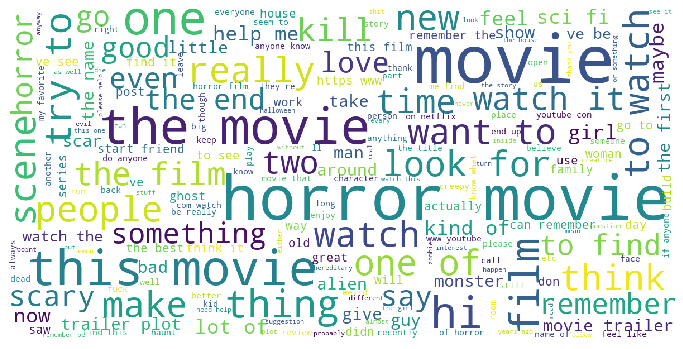

In [65]:
show_wordcloud(df_lemma['content'])

In [66]:
# Display top 10 words for processed data with lemmatization
words_lemma = features(df_lemma,y)

6167
Top 10 words


is_horror    0    1
movie      170  934
horror     7    661
watch      35   538
like       30   442
movies     30   434
film       51   384
just       13   323
remember   41   285
think      22   285
know       13   257

The number of words dropped further from xxx to xxx. The top common words have changed. trump is still leading, but russia is no where near the top now.

Let us find the best model for $M_2$.

In [68]:
# Enter what vectorizers and classifiers we want to use and find the best.

vectorizer = ['cv','tv']
classifier = ['lr','bnb','mnb','knn']
use_params = False

df_solns, X_train, X_test, y_train, train_score, test_score, y_test, y_test_hat, best_params, f1_score = search(vectorizer,classifier,df_lemma,y,use_params)

<b>Using CountVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.9123376623376623
Test score: 0.9253246753246753 (Accuracy)

True Negatives: 73
False Positives: 14 (Type I Error)
False Negatives: 9 (Type II Error)
True Positives: 212



/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>Sensitivity:</b> 0.9592760180995475

<b>Miss Rate:</b> 0.04072398190045249

<b>Specificity:</b> 0.8390804597701149

<b>Fall Out Rate:</b> 0.16091954022988506

<b>Precision:</b> 0.9380530973451328

<b>False Discovery Rate:</b> 0.061946902654867256

<b>Negative Predictive Value:</b> 0.8902439024390244

<b>False Omission Rate:</b> 0.10975609756097561

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9253246753246753

<b>Positive Likelihood Ratio:</b> 5.9612152553329025

<b>Negative Likelihood Ratio:</b> 0.04853406062108721

<b>Diagnostic Odds Ratio:</b> 122.82539682539682

<b>F1 Score:</b> 0.9485458612975392

<span style="color: red;"><b>****Completed CountVectorizer with LogisticRegression****<b></span>

<b>Using CountVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train score: 0.8127705627705628
Test score: 0.8246753246753247 (Accuracy)

True Negatives: 71
False Positives: 16 (Type I Error)
False Negatives: 38 (Type II Error)
True Positives: 183



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


<b>Sensitivity:</b> 0.8280542986425339

<b>Miss Rate:</b> 0.17194570135746606

<b>Specificity:</b> 0.8160919540229885

<b>Fall Out Rate:</b> 0.1839080459770115

<b>Precision:</b> 0.9195979899497487

<b>False Discovery Rate:</b> 0.08040201005025126

<b>Negative Predictive Value:</b> 0.6513761467889908

<b>False Omission Rate:</b> 0.3486238532110092

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8246753246753247

<b>Positive Likelihood Ratio:</b> 4.502545248868778

<b>Negative Likelihood Ratio:</b> 0.21069402842393728

<b>Diagnostic Odds Ratio:</b> 21.37006578947368

<b>F1 Score:</b> 0.8714285714285714

<span style="color: red;"><b>****Completed CountVectorizer with BernoulliNB****<b></span>

<b>Using CountVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train score: 0.8603896103896104
Test score: 0.8928571428571429 (Accuracy)

True Negatives: 54
False Positives: 33 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6206896551724138

<b>Fall Out Rate:</b> 0.3793103448275862

<b>Precision:</b> 0.8700787401574803

<b>False Discovery Rate:</b> 0.12992125984251968

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8928571428571429

<b>Positive Likelihood Ratio:</b> 2.6363636363636367

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9305263157894736

<span style="color: red;"><b>****Completed CountVectorizer with MultinomialNB****<b></span>

<b>Using CountVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished



Train score: 0.7824675324675324
Test score: 0.7857142857142857 (Accuracy)

True Negatives: 70
False Positives: 17 (Type I Error)
False Negatives: 49 (Type II Error)
True Positives: 172



<b>Sensitivity:</b> 0.7782805429864253

<b>Miss Rate:</b> 0.22171945701357465

<b>Specificity:</b> 0.8045977011494253

<b>Fall Out Rate:</b> 0.19540229885057472

<b>Precision:</b> 0.91005291005291

<b>False Discovery Rate:</b> 0.08994708994708994

<b>Negative Predictive Value:</b> 0.5882352941176471

<b>False Omission Rate:</b> 0.4117647058823529

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.7857142857142857

<b>Positive Likelihood Ratio:</b> 3.982965131754059

<b>Negative Likelihood Ratio:</b> 0.27556561085972847

<b>Diagnostic Odds Ratio:</b> 14.453781512605042

<b>F1 Score:</b> 0.8390243902439024

<span style="color: red;"><b>****Completed CountVectorizer with KNeighborsClassifier****<b></span>

<b>Using TfidfVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Train score: 0.8961038961038961
Test score: 0.9188311688311688 (Accuracy)

True Negatives: 66
False Positives: 21 (Type I Error)
False Negatives: 4 (Type II Error)
True Positives: 217



<b>Sensitivity:</b> 0.9819004524886877

<b>Miss Rate:</b> 0.01809954751131222

<b>Specificity:</b> 0.7586206896551724

<b>Fall Out Rate:</b> 0.2413793103448276

<b>Precision:</b> 0.9117647058823529

<b>False Discovery Rate:</b> 0.08823529411764706

<b>Negative Predictive Value:</b> 0.9428571428571428

<b>False Omission Rate:</b> 0.05714285714285714

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9188311688311688

<b>Positive Likelihood Ratio:</b> 4.067873303167421

<b>Negative Likelihood Ratio:</b> 0.023858494446729744

<b>Diagnostic Odds Ratio:</b> 170.49999999999997

<b>F1 Score:</b> 0.9455337690631808

<span style="color: red;"><b>****Completed TfidfVectorizer with LogisticRegression****<b></span>

<b>Using TfidfVectorizer with BernoulliNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train score: 0.8127705627705628
Test score: 0.8246753246753247 (Accuracy)

True Negatives: 71
False Positives: 16 (Type I Error)
False Negatives: 38 (Type II Error)
True Positives: 183



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


<b>Sensitivity:</b> 0.8280542986425339

<b>Miss Rate:</b> 0.17194570135746606

<b>Specificity:</b> 0.8160919540229885

<b>Fall Out Rate:</b> 0.1839080459770115

<b>Precision:</b> 0.9195979899497487

<b>False Discovery Rate:</b> 0.08040201005025126

<b>Negative Predictive Value:</b> 0.6513761467889908

<b>False Omission Rate:</b> 0.3486238532110092

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.8246753246753247

<b>Positive Likelihood Ratio:</b> 4.502545248868778

<b>Negative Likelihood Ratio:</b> 0.21069402842393728

<b>Diagnostic Odds Ratio:</b> 21.37006578947368

<b>F1 Score:</b> 0.8714285714285714

<span style="color: red;"><b>****Completed TfidfVectorizer with BernoulliNB****<b></span>

<b>Using TfidfVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Train score: 0.7435064935064936
Test score: 0.788961038961039 (Accuracy)

True Negatives: 22
False Positives: 65 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.25287356321839083

<b>Fall Out Rate:</b> 0.7471264367816092

<b>Precision:</b> 0.7727272727272727

<b>False Discovery Rate:</b> 0.22727272727272727

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.788961038961039

<b>Positive Likelihood Ratio:</b> 1.3384615384615386

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.8717948717948718

<span style="color: red;"><b>****Completed TfidfVectorizer with MultinomialNB****<b></span>

<b>Using TfidfVectorizer with KNeighborsClassifier</b>

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



Train score: 0.8571428571428571
Test score: 0.9025974025974026 (Accuracy)

True Negatives: 57
False Positives: 30 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.6551724137931034

<b>Fall Out Rate:</b> 0.3448275862068966

<b>Precision:</b> 0.8804780876494024

<b>False Discovery Rate:</b> 0.11952191235059761

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9025974025974026

<b>Positive Likelihood Ratio:</b> 2.9

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9364406779661016

<span style="color: red;"><b>****Completed TfidfVectorizer with KNeighborsClassifier****<b></span>

<span style="color: red;"><b>COMPLETED</b></span>

In [69]:
# Display the best model
df_solns = df_solns.sort_values(ascending=False, by='f1_score',axis=1)
df_solns.iloc[:,0:1]

1
vectorizer   cv      
model        lr      
train_score  0.912338
test_score   0.925325
best_params  {}      
f1_score     0.948546

For our $M_2$ model, we used TfidfVectorizer with LogisticRegression. However, the F1 Score dropped below the baseline score of xxx to xxx.

### $M_3$ - Final Model

From the past 3 models, we can determine that raw unprocessed data, without Lemmatization has the highest F1 Score. Now we will fit the same data, but we will introduce new parameters and find the best model.

Note that we will not be considering BernoulliNB and kNeighborsClassifer as it is giving us a poor F1 Score. We have also set our cv = 2 as we do not see an increase in the F1 Score above cv = 2.

In [75]:
my_additional_stop_words = [
                            'movie',
                            'plot', 
                            ] 
# Add my modified list of exceptions to the default list of stopwords                
modified_stop_word_list = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)


In [70]:
# Enter what vectorizers and classifiers we want to use and find the best.

vectorizer = ['cv','tv']
classifier = ['lr','mnb']
use_params = True

df_solns, X_train, X_test, y_train, train_score, test_score, y_test, y_test_hat, best_params, f1_score = search(vectorizer,classifier,df_master,y,use_params)

<b>Using CountVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/s

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

cv__max_df: 0.95
cv__max_features: 10000
cv__min_df: 1
cv__ngram_range: (1, 1)
cv__stop_words: english
lr__C: 1
lr__penalty: l2

Train score: 0.9199134199134199
Test score: 0.9318181818181818 (Accuracy)

True Negatives: 77
False Positives: 10 (Type I Error)
False Negatives: 11 (Type II Error)
True Positives: 210



[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:  1.8min finished
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>Sensitivity:</b> 0.9502262443438914

<b>Miss Rate:</b> 0.049773755656108594

<b>Specificity:</b> 0.8850574712643678

<b>Fall Out Rate:</b> 0.11494252873563218

<b>Precision:</b> 0.9545454545454546

<b>False Discovery Rate:</b> 0.045454545454545456

<b>Negative Predictive Value:</b> 0.875

<b>False Omission Rate:</b> 0.125

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9318181818181818

<b>Positive Likelihood Ratio:</b> 8.266968325791854

<b>Negative Likelihood Ratio:</b> 0.056237879767291526

<b>Diagnostic Odds Ratio:</b> 147.0

<b>F1 Score:</b> 0.9523809523809523

<span style="color: red;"><b>****Completed CountVectorizer with LogisticRegression****<b></span>

<b>Using CountVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:  1.1min finished


cv__max_df: 0.95
cv__max_features: 10000
cv__min_df: 2
cv__ngram_range: (1, 2)
cv__stop_words: english
mnb__alpha: 1.0

Train score: 0.9025974025974026
Test score: 0.9285714285714286 (Accuracy)

True Negatives: 65
False Positives: 22 (Type I Error)
False Negatives: 0 (Type II Error)
True Positives: 221



<b>Sensitivity:</b> 1.0

<b>Miss Rate:</b> 0.0

<b>Specificity:</b> 0.7471264367816092

<b>Fall Out Rate:</b> 0.25287356321839083

<b>Precision:</b> 0.9094650205761317

<b>False Discovery Rate:</b> 0.09053497942386832

<b>Negative Predictive Value:</b> 1.0

<b>False Omission Rate:</b> 0.0

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9285714285714286

<b>Positive Likelihood Ratio:</b> 3.954545454545454

<b>Negative Likelihood Ratio:</b> 0.0

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in double_scalars


<b>Diagnostic Odds Ratio:</b> inf

<b>F1 Score:</b> 0.9525862068965517

<span style="color: red;"><b>****Completed CountVectorizer with MultinomialNB****<b></span>

<b>Using TfidfVectorizer with LogisticRegression</b>

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/s

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

lr__C: 1
lr__penalty: l2
tv__max_df: 0.95
tv__max_features: 10000
tv__min_df: 2
tv__ngram_range: (1, 1)
tv__stop_words: None

Train score: 0.8993506493506493
Test score: 0.9155844155844156 (Accuracy)

True Negatives: 65
False Positives: 22 (Type I Error)
False Negatives: 4 (Type II Error)
True Positives: 217



<b>Sensitivity:</b> 0.9819004524886877

<b>Miss Rate:</b> 0.01809954751131222

<b>Specificity:</b> 0.7471264367816092

<b>Fall Out Rate:</b> 0.25287356321839083

<b>Precision:</b> 0.9079497907949791

<b>False Discovery Rate:</b> 0.09205020920502092

<b>Negative Predictive Value:</b> 0.9420289855072463

<b>False Omission Rate:</b> 0.057971014492753624

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9155844155844156

<b>Positive Likelihood Ratio:</b> 3.8829699712052648

<b>Negative Likelihood Ratio:</b> 0.024225548207448662

<b>Diagnostic Odds Ratio:</b> 160.28409090909088

<b>F1 Score:</b> 0.9434782608695652

<span style="color: red;"><b>****Completed TfidfVectorizer with LogisticRegression****<b></span>

<b>Using TfidfVectorizer with MultinomialNB</b>

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:  1.1min finished


mnb__alpha: 0.01
tv__max_df: 0.95
tv__max_features: 10000
tv__min_df: 1
tv__ngram_range: (1, 2)
tv__stop_words: english

Train score: 0.8917748917748918
Test score: 0.9090909090909091 (Accuracy)

True Negatives: 60
False Positives: 27 (Type I Error)
False Negatives: 1 (Type II Error)
True Positives: 220



<b>Sensitivity:</b> 0.995475113122172

<b>Miss Rate:</b> 0.004524886877828055

<b>Specificity:</b> 0.6896551724137931

<b>Fall Out Rate:</b> 0.3103448275862069

<b>Precision:</b> 0.8906882591093117

<b>False Discovery Rate:</b> 0.10931174089068826

<b>Negative Predictive Value:</b> 0.9836065573770492

<b>False Omission Rate:</b> 0.01639344262295082

<b>Prevalence:</b> 0.7175324675324676

<b>Accuracy:</b> 0.9090909090909091

<b>Positive Likelihood Ratio:</b> 3.207642031171443

<b>Negative Likelihood Ratio:</b> 0.006561085972850679

<b>Diagnostic Odds Ratio:</b> 488.8888888888889

<b>F1 Score:</b> 0.9401709401709402

<span style="color: red;"><b>****Completed TfidfVectorizer with MultinomialNB****<b></span>

<span style="color: red;"><b>COMPLETED</b></span>

In [71]:

# Display the best model
df_solns = df_solns.sort_values(ascending=False, by='f1_score',axis=1)
df_solns.iloc[:,0:1]

2
vectorizer   cv                                                                                                                                         
model        mnb                                                                                                                                        
train_score  0.902597                                                                                                                                   
test_score   0.928571                                                                                                                                   
best_params  {'cv__max_df': 0.95, 'cv__max_features': 10000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english', 'mnb__alpha': 1.0}
f1_score     0.952586

In [ ]:
cv__max_df': 0.95
 'cv__max_features': 10000,
'cv__min_df': 2, 'cv__ngram_range': (1, 2),
'cv__stop_words': 'english', 'mnb__alpha': 1.0}

In [ ]:
# Saving our best parameters for later use
best_alpha = 1.0
best_max_df = 0.95
best_max_features = None
best_min_df = 1
best_ngram_range = (1,2)
best_stop = None
best_classifier = 'mnb'
best_vectorizer = 'cv'

In [77]:
cv.get_feature_names()


NameError: name 'cv' is not defined

## Evaluating our Model

Let us display which of the content we predicted correctly.



In [72]:

X_test['is_horror'] = y_test.values
X_test['pred_horror'] = y_test_hat
X_test_true = X_test[X_test["is_horror"] == X_test['pred_horror']]
X_test_false = X_test[X_test["is_horror"] != X_test['pred_horror']]

/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/peecee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [119]:
X_test_true.shape


(280, 3)

In [120]:
X_test_false.shape

(28, 3)

In [74]:
X_test_false

is_horror  \
id                  
fbdwk6  0           
3fign3  0           
a9psm9  0           
6xiekd  0           
ab1hyd  0           
880cpn  0           
bie2zw  0           
5lzdy6  0           
8aunpg  0           
8cnlp4  0           
gd0j39  1           
f7z0bk  0           
8pr473  0           
gs51vr  0           
enf2qt  0           
43n3ul  0           
8r3yxd  0           
h9hrfy  0           
7uojry  0           
6irmt9  0           
1ir2qa  0           
bm1dl4  0           
cy5vmj  0           
92aewq  0           
fyhouu  0           
1twchq  0           
a9ewrs  0           
e6igbn  0           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          content  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
fbdwk6  search for a s sci fi movie hi i saw this movie as a kid timeframe can anyone help identify it please i can only remember scenes from the movie the crew be onboard a spaceship drift towards a black hole and they fire a laser beam toward the black hole and it bend toward the black hole they go through the black hole and emerge in another universe on the other side and it be multicoloured and that be all i can remember it wasn t disney black hole as that come out few years after any help appreciate thank                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
3fign3  need help identify old scifi movie about time travel i remember watch a scifi movie that be make either in the s or s the protagonists i think they be scientists be do some experiment with time travel at the very end of the movie after conclude their experiment the protagonists a man and a woman iirc exit the facility where they be work only to find that time have stop all ar

### Evaluation Metrics:
Micro-Averaged F1-Score (Mean F Score): The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
F1 = 2 * (precision * recall) / (precision + recall)
In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.
‘Micro f1 score’: Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

### Recommendations

In [ ]:
Future Work

An interesting thought that came into my mind but I wasn't able to implement was to make this a multi-modal classification problem.

We could use, say, the poster of the movie to use visual data along with the already present textual data to improve our classification accuracy. Though, I was not really sure about the mechanics of creating such a dataset and thus could act upon this idea.

If I get the time in the future, I would love to explore the muti-modal classification idea more.

Cheers.